In [140]:
try:
  from zoltpy import util, connection
except:
  !pip install pymmwr
  !pip install git+https://github.com/reichlab/zoltpy/
  from zoltpy import util, connection

try:
  from qenspy import qens
except:
  !pip install git+https://github.com/reichlab/qenspy@params
  from qenspy import qens

import os
from numpy.core.arrayprint import format_float_positional
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

In [141]:
# Download example forecast data from Zoltar
os.environ["Z_USERNAME"] = "zoltar_demo"
os.environ["Z_PASSWORD"] = "Dq65&aP0nIlG"
conn = util.authenticate()
project_name = 'COVID-19 Forecasts'

In [142]:
def query_project_forecasts_and_truth(conn, project_name, models, units, targets, timezeros, types):
  """Query forecasts and corresponding observed truth from Zoltar."""
  query = {
    "models": models,
    "units": units,
    "targets": targets,
    "timezeros": timezeros,
    "types": types}
  forecasts = util.query_project(conn, project_name, connection.QueryType.FORECASTS, query) \
    .assign(
      timezero = lambda x: pd.to_datetime(x.timezero),
      forecast_date = lambda x: x.timezero +
        x.timezero.dt.dayofweek.apply(lambda dow: pd.Timedelta(days = dow / 6)),
      value = lambda x: x.value.astype('float64')
    ) \
    [['model', 'unit', 'forecast_date', 'target', 'quantile', 'value']]
  
  query = {
    "units": units,
    "targets": targets,
    "timezeros": timezeros}
  truth = util.query_project(conn, project_name, connection.QueryType.TRUTH, query) \
    .assign(
      timezero = lambda x: pd.to_datetime(x.timezero),
      forecast_date = lambda x: x.timezero +
        x.timezero.dt.dayofweek.apply(lambda dow: pd.Timedelta(days = dow / 6)),
      value = lambda x: x.value.astype('float64')
    ) \
    [['unit', 'forecast_date', 'target', 'value']]
  
  return (forecasts, truth.drop_duplicates())

In [143]:
def q_df_to_array(q_df, tau_strs, models):
  """Convert predictive quantiles from a tidy data frame to a 3d array."""
  q_wide = q_df \
    .set_index(keys = ['unit', 'forecast_date', 'target', 'model', 'quantile']) \
    [['value']] \
    .unstack(['model', 'quantile'])
  model_cols = q_wide.columns.get_level_values(1)
  
  def model_q_ordered(model):
    df_one_model = q_wide.iloc[:, model_cols == model].droplevel([0, 1], axis = 1)
    return df_one_model[tau_strs].values
  
  q_arr = np.concatenate(
    [model_q_ordered(model)[..., np.newaxis] for model in models],
    axis = 2
  )
  
  return q_arr

In [144]:
def plot_forecasts(
  q,
  y,
  models,
  tau):
  """Plot observations and predictions."""
  fig, ax = plt.subplots(nrows=(len(models) + 1)//2, ncols=2, figsize=(12, 12))
  fig.set_tight_layout(True)
  
  interval_colors = ['#a6bddb', '#74a9cf', '#3690c0', '#0570b0']
  interval_labels = ['98%', '95%', '80%', '50%']
  
  for m in range(len(models)):
    row_ind = m // 2
    col_ind = m % 2
    
    ax[row_ind, col_ind].grid()
    ax[row_ind, col_ind].set_axisbelow(True)
    ax[row_ind, col_ind].set(
      xticks=np.linspace(1, 4, 4),
      xlabel='Forecast Horizon',
      ylabel='',
      title=models[m])
    #ax[row_ind, col_ind].yaxis.set_major_formatter(mtick.StrMethodFormatter('{:s}')) #%8d
    ax[row_ind, col_ind].yaxis.set_major_formatter(mtick.FormatStrFormatter('%8d')) #
    #ax[row_ind, col_ind].text(0,1,models[m],ha='right',va='top',transform=ax[row_ind, col_ind].transAxes,weight='bold')
    
    # Prediction intervals
    for interval_ind, half_alpha in enumerate([0.01, 0.025, 0.1, 0.25]):
      k_lower = np.where(abs(tau - half_alpha) < 1e-7)
      k_upper = np.where(abs(tau - (1 - half_alpha)) < 1e-7)
      ax[row_ind, col_ind].fill_between(
        np.linspace(1, 4, 4),
        q[:, k_lower, m].reshape(4),
        q[:, k_upper, m].reshape(4),
        color = interval_colors[interval_ind],
        label = interval_labels[interval_ind])
    
    # train set data
    ax[row_ind, col_ind].plot(
        np.linspace(1, 4, 4),
        y,
        'orange',
        label = "Observed")
    
    # plot predictive median
    k_median = np.where(abs(tau - 0.5) < 1e-7)
    ax[row_ind, col_ind].plot(
        np.linspace(1, 4, 4),
        q[:, k_median, m].reshape(4),
        '#034e7b',
        ls='--',
        lw=3.0,
        label = "Forecast")
    
    if m == 0:
      ax[row_ind, col_ind].legend(loc='upper right', ncol=3)
  
  plt.show()

In [145]:
# load forecasts and data from Zoltar
models = ["epiforecasts-ensemble1", "LNQ-ens1", "UMass-MechBayes"]
units = ["39"]
targets = [str(h + 1) + ' wk ahead inc death' for h in range(4)]
types = ["quantile"]
train_timezeros = ['2021-01-17', '2021-01-18', '2021-01-24', '2021-01-25',
  '2021-01-31', '2021-02-01', '2021-02-07', '2021-02-08']
test_timezeros = ['2021-02-14', '2021-02-15']

In [146]:
tau_strs = ['0.01', '0.025']
tau_strs.extend(
  [np.format_float_positional(x, 2) for x in np.linspace(0.05, 0.95, 19)])
tau_strs.extend(['0.975', '0.99'])
tau = tf.constant(np.array(tau_strs).astype('float64'))


In [147]:
(train_forecasts, train_truth) = query_project_forecasts_and_truth(
  conn=conn,
  project_name=project_name,
  models=models,
  units=units,
  targets=targets,
  timezeros=train_timezeros,
  types=types)


* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/53041/', 53041)
- QUEUED
- SUCCESS

* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/53042/', 53042)
- QUEUED
- SUCCESS


In [148]:
(test_forecasts, test_truth) = query_project_forecasts_and_truth(
  conn=conn,
  project_name=project_name,
  models=models,
  units=units,
  targets=targets,
  timezeros=test_timezeros,
  types=types)



* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/53043/', 53043)
- QUEUED
- SUCCESS

* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/53044/', 53044)
- QUEUED
- SUCCESS


In [149]:
q_train = tf.constant(q_df_to_array(train_forecasts, tau_strs, models))
y_train = tf.constant(train_truth['value'].values)

q_test = tf.constant(q_df_to_array(test_forecasts, tau_strs, models))
y_test = tf.constant(test_truth['value'].values)

In [150]:
# illustrate calculation of equal-weighted mean ensemble
K = len(tau)
M = len(models)

w_equal = tf.constant(np.full((K, M), 1./M))
q_equal_mean = qens.MeanQEns().predict(q_test, w={'w': w_equal})

In [151]:
# fit a weighted mean ensemble
tau_groups = np.zeros(len(tau))
init_param_vec = tf.constant(np.zeros(2))

q_weighted_mean = qens.MeanQEns()
q_weighted_mean.fit(y_train, q_train, tau, tau_groups, init_param_vec, optim_method="adam", num_iter=1000, learning_rate=0.1, verbose = False)

In [153]:
# the estimated weights
q_weighted_mean.unpack_params(q_weighted_mean.get_param_estimates_vec(), M, tau_groups)

{'w': <tf.Tensor: shape=(23, 3), dtype=float64, numpy=
 array([[4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.16631556e-04, 2.40039038e-04, 9.99343329e-01],
        [4.166315

In [154]:
# illustrate calculation of unequal-weighted mean ensemble predictions
q_weighted_mean = qens.MeanQEns().predict(
    q_test,
    w=q_weighted_mean.unpack_params(q_weighted_mean.get_param_estimates_vec(), M, tau_groups))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


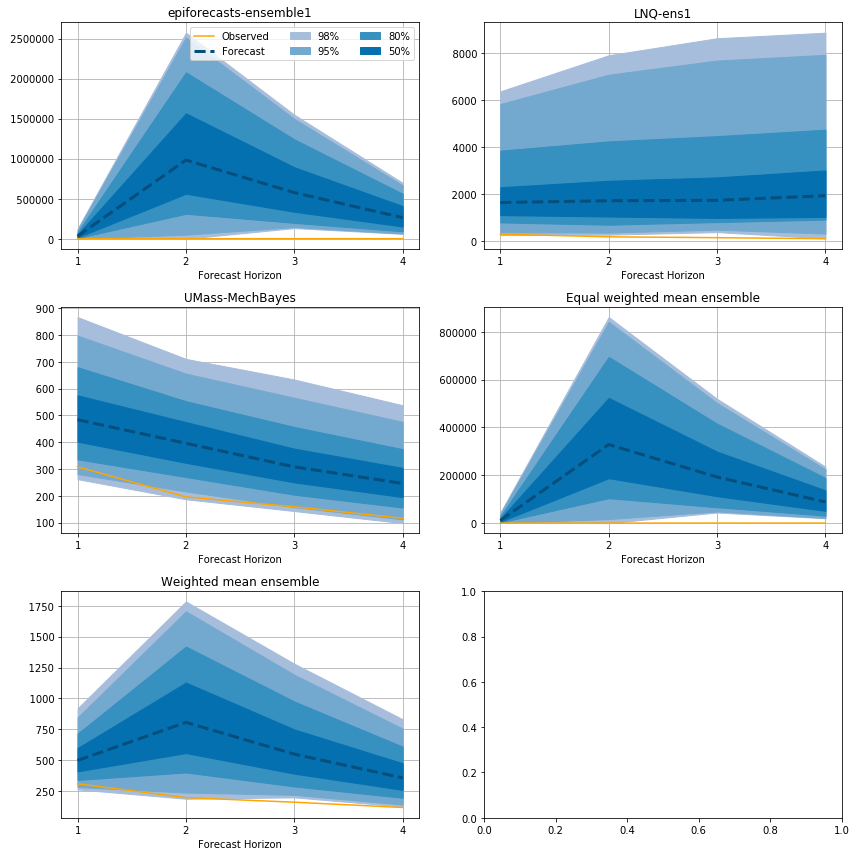

In [155]:
# make a plot
q_combined = np.concatenate([q_test, q_equal_mean[..., np.newaxis], q_weighted_mean[..., np.newaxis]], axis = 2)
models_combined = models.copy()
models_combined.append('Equal weighted mean ensemble')
models_combined.append('Weighted mean ensemble')

plot_forecasts(
  q = q_combined,
  y = y_test,
  models = models_combined,
  tau = tau)